## Topic Modeling
### Conducting LDA topic modeling on news database

In [2]:
import pandas as pd
import numpy as np
from scipy.linalg import norm, eigh
from sklearn.decomposition import PCA
import plotly_express as px
from scipy.linalg import eigh
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from scipy.linalg import eigh
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px
from gensim.models import word2vec
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

In [5]:
CORPUS = pd.read_csv("C:/Users/Student/Desktop/UVA/UVA '23 Spring/DS 5001/Final Project/CORPUS.csv")
LIB = pd.read_csv("C:/Users/Student/Desktop/UVA/UVA '23 Spring/DS 5001/Final Project/LIB.csv")
VOCAB = pd.read_csv("C:/Users/Student/Desktop/UVA/UVA '23 Spring/DS 5001/Final Project/VOCAB.csv")

In [6]:
CORPUS.sample(5)

,Unnamed: 0,text_num,para_num,sent_num,token_num,pos_tuple,pos,token_str,term_str,source
246732,246732,250,21,0,7,"('their', 'PRP$')",PRP$,their,their,CNN
515065,515065,563,1,0,34,"('long', 'JJ')",JJ,long,long,CNBC
534880,534880,591,11,0,11,"('cnbc', 'NN')",NN,cnbc,cnbc,CNBC
264519,264519,272,0,0,13,"('morning', 'NN')",NN,morning,morning,CNN
704946,704946,832,3,2,10,"('fisher', 'NN')",NN,fisher,fisher,CNBC


In [7]:
OHCO = ['source', 'text_num', 'para_num', 'sent_num', 'token_num']
SENTS = OHCO[:4]
PARAS = OHCO[:3]
ARTICLES = OHCO[:2]
SOURCES = OHCO[:1]

In [8]:
# setting parameters
ngram_range = (1,2)
max_features = 4000 # CountVectorizer max features parameter
stop_words = 'english'
n_components = 20
max_iter = 5
learning_offset = 50.
random_state = 0
num_words_to_characterize = 7 

In [9]:
def topic_model_generator(BAG, TOKENS):
    # filter for nouns (NN and NNS hyperparameters)
    DOCS = TOKENS[TOKENS.pos.isin(['NN','NNS'])]\
        .groupby(BAG).term_str\
        .apply(lambda x: ' '.join(x))\
        .to_frame()\
        .rename(columns={'term_str':'doc_str'})
    
    # create vector space
    count_engine = CountVectorizer(max_features=max_features, ngram_range=ngram_range, stop_words=stop_words)
    count_model = count_engine.fit_transform(DOCS.doc_str)
    TERMS = count_engine.get_feature_names_out()
    VOCAB = pd.DataFrame(index=TERMS)
    VOCAB.index.name = 'term_str'
    DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)
    VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
    DOCS['term_count'] = DTM.sum(1)
    
    # generate moddel
    lda_engine = LDA(n_components=n_components, max_iter=max_iter, learning_offset=learning_offset, random_state=random_state)
    
    # topic names
    TNAMES = [f"T{str(x).zfill(len(str(n_components)))}" for x in range(n_components)]
    
    # THETA
    lda_model = lda_engine.fit_transform(count_model)
    THETA = pd.DataFrame(lda_model, index=DOCS.index)
    THETA.columns.name = 'topic_id'
    THETA.columns = TNAMES
    
    # PHI
    PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
    PHI.index.name = 'topic_id'
    PHI.columns.name  = 'term_str'
    
    # inspect results
    # create TOPICS & get Top Terms per Topic
    TOPICS = PHI.stack().to_frame('topic_weight').groupby('topic_id')\
        .apply(lambda x: x.sort_values('topic_weight', ascending=False)\
        .head(num_words_to_characterize).reset_index().drop('topic_id', axis=1)['term_str'])
    TOPICS['label'] = TOPICS.apply(lambda x: x.name + ' ' + ', '.join(x[:num_words_to_characterize]), 1)
    
     # sort topics by Doc Weight
    TOPICS['doc_weight_sum'] = THETA.sum()
    TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()
    
    return THETA, PHI, TOPICS

In [10]:
scene_as_bag = ARTICLES
THETA_PARA, PHI_PARA, TOPICS_PARA = topic_model_generator(scene_as_bag, CORPUS)

In [11]:
colors = "YlGnBu"
THETA_PARA.sample(20).style.background_gradient(cmap=colors, axis=None)

In [12]:
TOPICS_PARA

term_str,0,1,2,3,4,5,6,label,doc_weight_sum,term_freq
topic_id,,,,,,,,,,
T00,police,people,family,taylor,officers,cnn,life,"T00 police, people, family, taylor, officers, ...",69.222423,0.049714
T01,share,checks,people,cents,revenue,premarket,cents share,"T01 share, checks, people, cents, revenue, pre...",33.457869,0.030492
T02,trump,court,president,justice,department,law,case,"T02 trump, court, president, justice, departme...",59.098367,0.070633
T03,tax,taxes,world,states,year,scientists,people,"T03 tax, taxes, world, states, year, scientist...",32.798044,0.025902
T04,people,group,children,health,activity,women,adults,"T04 people, group, children, health, activity,...",27.990425,0.025968
T05,biden,president,policy,women,trump,years,country,"T05 biden, president, policy, women, trump, ye...",32.265093,0.032680
T06,companies,company,cramer,year,time,business,market,"T06 companies, company, cramer, year, time, bu...",60.442268,0.044070
T07,president,house,trump,presidents,health,president donald,donald,"T07 president, house, trump, presidents, healt...",28.054252,0.044080
T08,money,house,benefits,tax,democrats,relief,week,"T08 money, house, benefits, tax, democrats, re...",84.779509,0.082605


In [13]:
PHI_PARA.T.sample(20).style.background_gradient(cmap=colors, axis=None)

topic_id,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19
term_str,,,,,,,,,,,,,,,,,,,,
users,0.195203,0.050000,0.050000,0.050000,0.050000,0.050000,4.588896,0.050000,0.050000,11.407414,0.050000,0.050000,0.050000,9.380633,3.688215,4.292005,1.771692,0.050000,0.050000,0.075941
voters share,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,26.049101,0.050000,0.050000,0.050000,0.050899
friend,7.852423,3.044683,0.167601,2.360599,6.626974,4.679906,0.050000,0.050000,0.050000,0.050000,3.361677,0.051390,12.069107,0.050000,3.997514,0.050000,0.050000,0.050000,1.866723,9.521401
need,13.209086,0.050000,0.265079,3.195894,5.761659,4.616395,9.851778,0.066498,14.101974,2.767574,3.565335,1.451654,0.050000,0.050000,8.325436,0.120338,0.050000,0.050000,4.401301,0.050000
counsel,0.050000,0.050000,46.261292,0.365445,0.050000,0.050000,0.050000,0.050000,0.050000,0.833331,9.168786,0.050000,39.370182,0.050000,0.050000,0.050000,0.050000,0.050000,13.950307,4.400657
rudy,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,2.666661,0.050000,3.801917,11.195716,0.050000,11.612639,0.050000,1.843656,0.050000,0.050000,0.515594,7.713817,0.050001
camera,17.447207,0.050000,0.147936,0.050000,0.050000,0.050000,1.620016,0.050000,0.050601,0.050451,5.669315,0.050000,2.890183,0.050000,2.702534,0.050000,2.383156,0.050000,4.538599,0.050000
jury subpoena,0.050000,0.050000,12.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
korea,0.050000,2.063342,3.050000,4.255425,0.050000,2.174345,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,2.706888,0.050000,0.050000,0.050000,0.050000


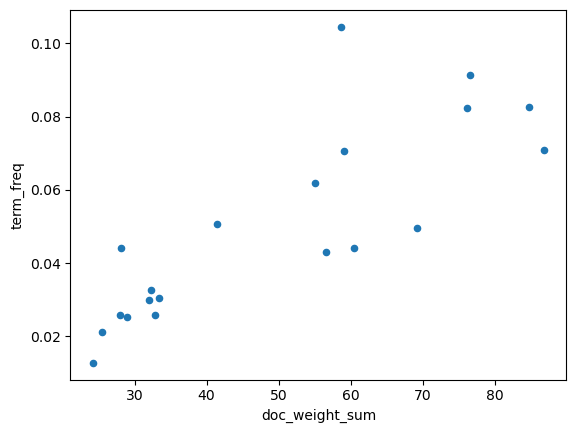

In [14]:
TOPICS_PARA.plot.scatter('doc_weight_sum', 'term_freq');